# Model Training

Here we will use the augmented dataset we created at data-prep.ipynb.

We will split the dataset into *train*, *validation* and *test* sets with respect to ratios ***0.7***, ***0.1*** and ***0.2***.

Later we will use a modified version of ResNet we call from ***model.py*** under **scripts** folder. We will train the model, save train loss and validaiton loss. Moreover, save the best model and later on use it to evaluate on test set.

In [1]:
import sys
# Add parent directory to the module search path
sys.path.append('../')

In [2]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator

# Import custom classes and functions defined under scripts folder
from scripts.data import FacialKeypointsDataset
from scripts.model import ResNet
from scripts.utils import count_parameters, df_results
from scripts.train import train_model, evaluate

In [3]:
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [4]:
# Read augmented data
aug_data = pd.read_csv('../data/augmented_data.csv')
# Format and reshape Image data
aug_data['Image'] = aug_data['Image'].apply(lambda x: np.fromstring(x, dtype= float, sep = ' ').reshape(96,96))

In [5]:
# Split into train, test, and validation sets
train_data, test_data = train_test_split(aug_data, test_size=0.3, random_state=seed)
test_data, val_data = train_test_split(test_data, test_size=0.33, random_state=seed)

In [6]:
# Define the transformations: Converting to tensor and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.)  # Normalize by dividing by 255
])

# Define datasets
train_dataset = FacialKeypointsDataset(train_data, transform)
test_dataset = FacialKeypointsDataset(test_data, transform)
val_dataset = FacialKeypointsDataset(val_data, transform)


In [7]:
model = ResNet() # Initialize the ResNet model
print(f'The model has {count_parameters(model):,} trainable parameters')
model # Display the model's architecture

The model has 11,716,254 trainable parameters


ResNet(
  (pad): ZeroPad2d((3, 3, 3, 3))
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (res2): ConvBlock(
    (main_path): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut_path): Sequential(
      (0): Conv2d(64, 256, kernel_size=

In [8]:
# Set the device to CUDA if it's available; otherwise, use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device is : {device}")

Current device is : cuda


In [9]:
BATCH_SIZE = 32

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# Move the model to the device (CPU or GPU) that will be used for computation
model = model.to(device)

# Define the loss function as Mean Squared Error (MSE), and move it to the computation device
# This will be used to measure the difference between the model's predictions and the true values
criterion = nn.MSELoss().to(device)

# Define the optimization algorithm as Adam
# This will be used to update the model's parameters based on the gradients computed during backpropagation
# The optimizer will optimize the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

In [11]:
# Define the total number of epochs to train for
EPOCHS = 25

# Initialize lists to hold the training and validation losses
train_losses = []
valid_losses = []

# Initialize the best validation loss as infinity. 
# This will be updated with the best (lowest) validation loss observed during training
best_valid_loss = float('inf')

# Loop over each epoch
for epoch in range(EPOCHS):
    # Train the model on the training data and compute the training loss
    train_loss = train_model(model, train_dataloader, optimizer, criterion, device)
    # Evaluate the model on the validation data and compute the validation loss
    valid_loss = evaluate(model, val_dataloader, criterion, device)

    # Append the training and validation losses for this epoch to the respective lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # If this epoch's validation loss is lower than the best validation loss seen so far
    if valid_loss < best_valid_loss:
        # Update the best validation loss
        best_valid_loss = valid_loss
        # Save the model's state dictionary as the new best model
        torch.save(model.state_dict(), '../results/Best_Model.pt')

    # Print the epoch number, training loss, and validation loss
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

# Use the 'df_results' function to create a DataFrame of the training stats and save it as a .csv file
train_stats = df_results(EPOCHS, train_losses, valid_losses, "train-stats")


Epoch 1/25, Train Loss: 364.0555, Valid Loss: 245.6677


Epoch 2/25, Train Loss: 123.8797, Valid Loss: 138.7000


Epoch 3/25, Train Loss: 93.3750, Valid Loss: 85.9929


Epoch 4/25, Train Loss: 76.9593, Valid Loss: 115.9847


Epoch 5/25, Train Loss: 67.7917, Valid Loss: 96.5107


Epoch 6/25, Train Loss: 56.9594, Valid Loss: 65.2856


Epoch 7/25, Train Loss: 50.2137, Valid Loss: 59.0505


Epoch 8/25, Train Loss: 45.3081, Valid Loss: 87.8427


Epoch 9/25, Train Loss: 48.3526, Valid Loss: 61.1524


Epoch 10/25, Train Loss: 36.1369, Valid Loss: 49.4460


Epoch 11/25, Train Loss: 41.5786, Valid Loss: 55.7586


Epoch 12/25, Train Loss: 34.8920, Valid Loss: 41.5086


Epoch 13/25, Train Loss: 30.5005, Valid Loss: 38.2790


Epoch 14/25, Train Loss: 29.4497, Valid Loss: 47.6002


Epoch 15/25, Train Loss: 32.8368, Valid Loss: 40.4952


Epoch 16/25, Train Loss: 29.2725, Valid Loss: 46.1692


Epoch 17/25, Train Loss: 26.0737, Valid Loss: 37.2234


Epoch 18/25, Train Loss: 28.1046, Valid Loss: 43.9182


Epoch 19/25, Train Loss: 27.6712, Valid Loss: 48.2882


Epoch 20/25, Train Loss: 25.9605, Valid Loss: 40.2805


Epoch 21/25, Train Loss: 24.5763, Valid Loss: 37.9954


Epoch 22/25, Train Loss: 26.7757, Valid Loss: 35.2576


Epoch 23/25, Train Loss: 23.4667, Valid Loss: 48.3527


Epoch 24/25, Train Loss: 22.3749, Valid Loss: 34.3027


Epoch 25/25, Train Loss: 18.7676, Valid Loss: 41.1390


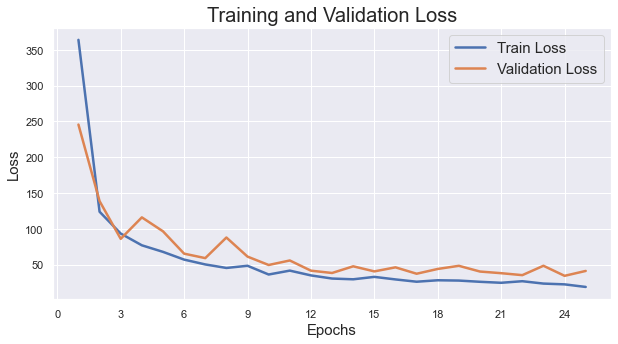

In [12]:
# Set style of seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))

# Plotting train loss
sns.lineplot(x=train_stats['epoch'], y=train_stats['train_loss'], label='Train Loss', linewidth=2.5)
# Plotting validation loss
sns.lineplot(x=train_stats['epoch'], y=train_stats['valid_loss'], label='Validation Loss', linewidth=2.5)

# Giving the plot a title
plt.title('Training and Validation Loss', fontsize=20)

# Labelling the x and y axis
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

# Displaying legend and specifying its location
plt.legend(prop={'size': 15}, loc='upper right')

# Making sure x-axis only displays integer epochs
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

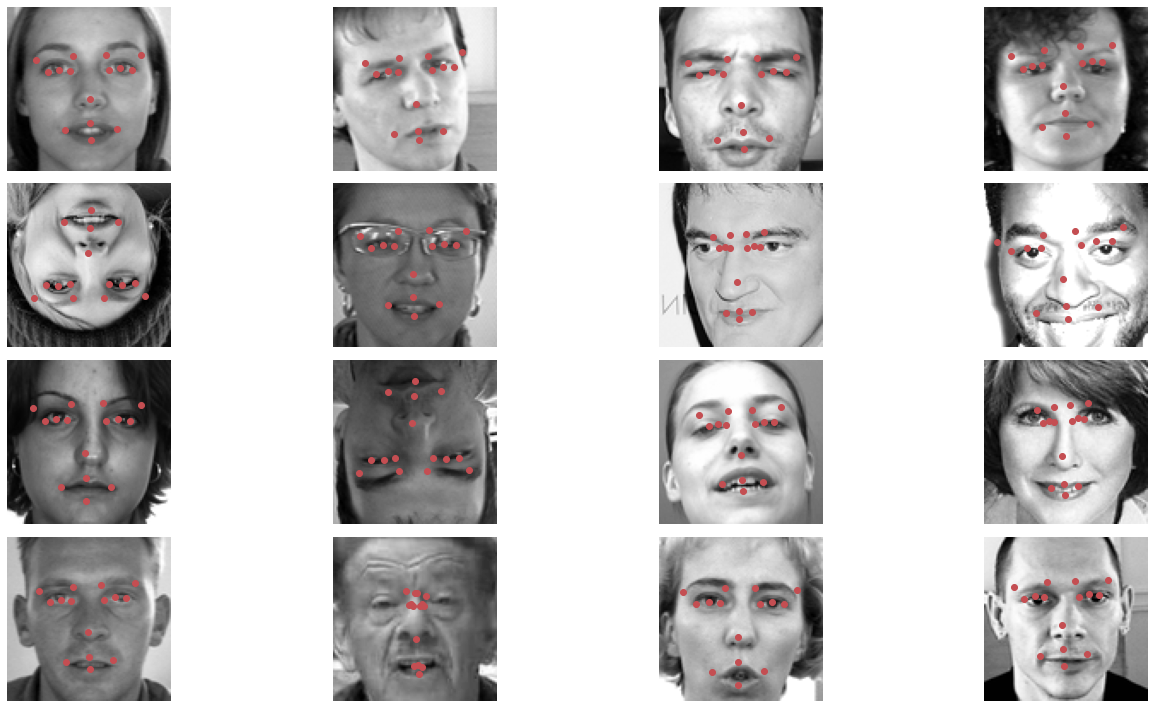

In [13]:
# Set model to evaluation mode
best_model = ResNet()
best_model.load_state_dict(torch.load('../results/Best_Model.pt'))
best_model.to(device)

# Select a batch of data
images, keypoints = next(iter(test_dataloader))
images = images.float().to(device)
keypoints = keypoints.view(keypoints.size(0), -1, 2) # reshape to (batch_size, 15, 2)

# Forward pass through the model to get the outputs
with torch.no_grad():
    outputs = best_model(images)
outputs = outputs.view(outputs.size(0), -1, 2).cpu().numpy() # reshape to (batch_size, 15, 2) and move to cpu

# Plot the images with predicted keypoints
fig, axes = plt.subplots(4, 4, figsize=(20, 10)) # change the numbers according to your batch size
axes = axes.ravel()

for i in range(16): # change the number according to your batch size
    axes[i].imshow(images[i][0].cpu(), cmap='gray') # plot the image
    axes[i].scatter(outputs[i, :, 0], outputs[i, :, 1], color='r') # plot the predicted keypoints
    axes[i].axis('off')

plt.tight_layout()